# Эмитация сенсора

In [30]:
import matplotlib.pyplot as plt
import numpy.random as random
import math
class DogSensor(object):
    def __init__(self, x0=0, velocity=1, noise=0.0):
        """ x0 - initial position
            velocity - (+=right, -=left)
            noise - scaling factor for noise, 0== no noise
        """
        self.x = x0
        self.velocity = velocity
        self.noise = math.sqrt(noise)
    def sense(self):
        self.x = self.x + self.velocity
        return self.x + random.randn() * self.noise


In [34]:
for i in range(20):
    print("{: 5.4f}".format(random.randn()),end="\t")
    if (i+1) % 5 == 0:
        print ("")

 0.9422	-0.0559	 1.9012	-0.8926	 1.3191	
-0.4445	 0.2824	 0.7390	-1.5982	-0.1805	
 0.0927	-1.2905	-0.1305	 2.6394	-0.7888	
 0.1981	 0.1403	 0.5570	-1.1332	-1.0484	


1.0000 2.0000 3.0000 4.0000 5.0000 6.0000 7.0000 8.0000 9.0000 10.0000 

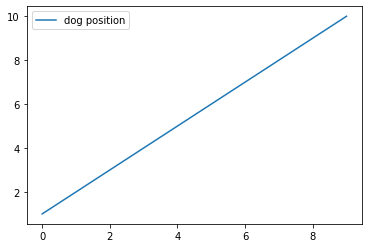

In [36]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
dog = DogSensor (noise=0.0)
xs = []
for i in range(10):
    x = dog.sense()
    xs.append(x)
    print("%.4f" % x, end=" "),
plt.plot(xs, label="dog position")
plt.legend(loc="best")
plt.show()

In [46]:
def test_sensor(noise_scale):
    dog = DogSensor(noise=noise_scale)
    xs = []
    for i in range(100):
        x = dog.sense()
        xs.append(x)
    plt.plot(xs, label="sensor")
    plt.plot([0,99],[1,100], "r--", label="actual")
    plt.xlabel("time")
    plt.ylabel("pos")
    plt.ylim([0,100])
    plt.title("noise = " + str(noise_scale))
    plt.legend(loc="best")
    plt.show()
test_sensor(4.0)

# Фильтор Калмана

In [52]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import numpy.random as random
import math

def dog_tracking_filter(R,Q=0,cov=1.):
    dog_filter = KalmanFilter (dim_x=2, dim_z=1)
    dog_filter.x = np.array([[0], [0]]) # initial state (location and velocity)
    dog_filter.F = np.array([[1,1], [0,1]]) # state transition matrix
    dog_filter.H = np.array([[1,0]]) # Measurement function
    dog_filter.R *= R # measurement uncertainty
    dog_filter.P *= cov # covariance matrix
    if np.isscalar(Q):
        dog_filter.Q = Q_DWPA(2, sigma=Q)
    else:
        dog_filter.Q = Q
    return dog_filter

In [53]:
def filter_dog(noise=0, count=0, R=0, Q=0, P=500., data=None, initial_x=None):
    """ Kalman filter ’count’ readings from the DogSensor.
        ’noise’ is the noise scaling factor for the DogSensor.
        ’data’ provides the measurements. If set, noise will
        be ignored and data will not be generated for you.
        returns a tuple of (positions, measurements, covariance)
    """
    if data is None:
        dog = DogSensor(velocity=1, noise=noise)
        zs = [dog.sense() for t in range(count)]
    else:
        zs = data

    dog_filter = dog_tracking_filter(R=R, Q=Q, cov=P)
    if initial_x is not None:
        dog_filter.x = initial_x
        
    pos = [None] * count
    cov = [None] * count
    
    for t in range(count):
        z = zs[t]
        pos[t] = dog_filter.x[0,0]
        cov[t] = dog_filter.P
        
        # perform the kalman filter steps
        dog_filter.update (z)
        dog_filter.predict()
        
    return (pos, zs, cov)

In [54]:
def plot_track(noise=None, count=0, R=0, Q=0, P=500., initial_x=None, data=None, plot_P=True, title="Kalman Filter"):
    
    ps, zs, cov = filter_dog(noise=noise, data=data, count=count, R=R, Q=Q, P=P, initial_x=initial_x)
    
    p0, = plt.plot([0,count],[0,count])
    p1, = plt.plot(range(1,count+1),zs, linestyle="dashed")
    p2, = plt.plot(range(1,count+1),ps)
    plt.legend([p0,p1,p2], ["actual","measurement", "filter"], loc=2)
    plt.ylim((0-10,count+10))
    plt.title(title)
    plt.show()
    
    if plot_P:
        plt.subplot(121)
        plot_covariance(cov, (0,0))
        plt.subplot(122)
        plot_covariance(cov, (1,1))
        plt.show()

def plot_covariance(P, index=(0,0)):
    ps = []
    for p in P:
        ps.append(p[index[0],index[1]])
    plt.plot(ps)

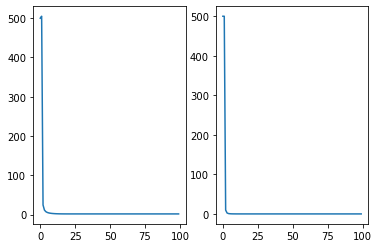

In [57]:
plot_track(noise=30, R=5, Q=0.01, count=100)

In [56]:
def Q_DWPA(dim, dt=1., sigma=1.):
    """ Returns the Q matrix for the Discrete Wiener Process Acceleration Model.
        dim may be either 2 or 3, dt is the time step, and sigma is the variance in
        the noise"""
    assert dim == 2 or dim == 3
    if dim == 2:
        Q = np.array([[.25*dt**4, .5*dt**3], [ .5*dt**3, dt**2]], dtype=float)
    else:
        Q = np.array([[.25*dt**4, .5*dt**3, .5*dt**2], [ .5*dt**3, dt**2, dt], [ .5*dt**2, dt, 1]], dtype=float)
    return Q * sigma